In [1]:
import numpy as np 
import statistics
from tqdm import tqdm
from scipy.stats import norm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
risk_free_rate=0.02
current_price=100
volatility=0.25
strike_price=105
maturity_time_in_month=2
maturity_time_in_year=maturity_time_in_month/12 #1/6
number_of_calculations_for_one_week_unit_time=maturity_time_in_month*4 #8
delta_t=1/48
sample_size=10000

#1. Monte Carlo Simulation

## (a)

In [3]:
all_path=[]
for i in range(sample_size):
  path_list=[]
  path_list.append(current_price)
  for j in range(number_of_calculations_for_one_week_unit_time):
    value=path_list[-1]*np.exp((risk_free_rate-(volatility**2)/2)*delta_t+volatility*np.sqrt(delta_t)*np.random.normal(0,1))
    path_list.append(value)
  all_path.append(path_list)


def price_option(all_path,option_type,risk_free_rate,current_price,volatility,maturity_time_in_month,maturity_time_in_year,
                     number_of_calculations_for_one_week_unit_time,delta_t,sample_size):

  sample_price_list=[]
  for i in range(sample_size):
    avg_value=sum(all_path[i])/len(all_path[i])
    max_value=max(all_path[i])
    min_value=min(all_path[i])
    if option_type=='Asian call':
      if avg_value>strike_price:
        sample_price_list.append((avg_value-strike_price)*np.exp(-risk_free_rate*maturity_time_in_year))
      else:
        sample_price_list.append(0)
    if option_type=='Asian put':
      if strike_price>avg_value:
        sample_price_list.append((strike_price-avg_value)*np.exp(-risk_free_rate*maturity_time_in_year))
      else:
        sample_price_list.append(0)
    if option_type=='Lookback call':
      if max_value>strike_price:
        sample_price_list.append((max_value-strike_price)*np.exp(-risk_free_rate*maturity_time_in_year))
      else:
        sample_price_list.append(0)
    if option_type=='Lookback put':
      if strike_price>min_value:
        sample_price_list.append((strike_price-min_value)*np.exp(-risk_free_rate*maturity_time_in_year))
      else:
        sample_price_list.append(0)
    if option_type=='Floating lookback call':
      if all_path[i][-1]>min_value:
        sample_price_list.append((all_path[i][-1]-min_value)*np.exp(-risk_free_rate*maturity_time_in_year))
      else:
        sample_price_list.append(0)
    if option_type=='Floating lookback put':
      if max_value>all_path[i][-1]:
        sample_price_list.append((max_value-all_path[i][-1])*np.exp(-risk_free_rate*maturity_time_in_year))
      else:
        sample_price_list.append(0)
  
  avg_price=statistics.mean(sample_price_list)
  std_price=statistics.stdev(sample_price_list)
  print(option_type,':')
  print('Price:')
  print(avg_price)
  print('95% confidence interval:')
  print('[',avg_price-1.96*std_price/np.sqrt(sample_size),',',avg_price+1.96*std_price/np.sqrt(sample_size),']')
  print('')
  


In [4]:
price_option(all_path,'Asian call',risk_free_rate,current_price,volatility,maturity_time_in_month,maturity_time_in_year,
                 number_of_calculations_for_one_week_unit_time,delta_t,sample_size)
price_option(all_path,'Asian put',risk_free_rate,current_price,volatility,maturity_time_in_month,maturity_time_in_year,
                 number_of_calculations_for_one_week_unit_time,delta_t,sample_size)
price_option(all_path,'Lookback call',risk_free_rate,current_price,volatility,maturity_time_in_month,maturity_time_in_year,
                 number_of_calculations_for_one_week_unit_time,delta_t,sample_size)
price_option(all_path,'Lookback put',risk_free_rate,current_price,volatility,maturity_time_in_month,maturity_time_in_year,
                 number_of_calculations_for_one_week_unit_time,delta_t,sample_size)
price_option(all_path,'Floating lookback call',risk_free_rate,current_price,volatility,maturity_time_in_month,maturity_time_in_year,
                 number_of_calculations_for_one_week_unit_time,delta_t,sample_size)
price_option(all_path,'Floating lookback put',risk_free_rate,current_price,volatility,maturity_time_in_month,maturity_time_in_year,
                 number_of_calculations_for_one_week_unit_time,delta_t,sample_size)

Asian call :
Price:
0.6725336621744998
95% confidence interval:
[ 0.6355486816173004 , 0.7095186427316993 ]

Asian put :
Price:
5.506319722707427
95% confidence interval:
[ 5.415376659876888 , 5.597262785537965 ]

Lookback call :
Price:
3.3254554637848743
95% confidence interval:
[ 3.222330220260099 , 3.4285807073096497 ]

Lookback put :
Price:
11.009364542347674
95% confidence interval:
[ 10.900066433650245 , 11.118662651045103 ]

Floating lookback call :
Price:
6.256561467723606
95% confidence interval:
[ 6.129227373037623 , 6.383895562409589 ]

Floating lookback put :
Price:
6.3226055692086485
95% confidence interval:
[ 6.210251872685421 , 6.434959265731876 ]



## (b)

In [5]:
def price_american_put_option(risk_free_rate,current_price,volatility,maturity_time_in_month,maturity_time_in_year,
                     number_of_calculations_for_one_week_unit_time,delta_t,sample_size):
  sample_stop_time=[]
  sample_price_list=[]

  for i in tqdm(range(sample_size)):
    stop_time=None
    value=current_price
    for j in range(number_of_calculations_for_one_week_unit_time):
      remain_time=maturity_time_in_year-j*delta_t
      value=value*np.exp((risk_free_rate-(volatility**2)/2)*delta_t+volatility*np.sqrt(delta_t)*np.random.normal(0,1))

      if remain_time!=0:
        d_1=(np.log(value/strike_price)+(risk_free_rate+(volatility**2)/2)*remain_time)/(volatility*np.sqrt(remain_time))
        d_2=d_1-(volatility*np.sqrt(remain_time))
      else:
        if value<strike_price:
          d_1=-np.inf
          d_2=d_1
        else:
          d_1=np.inf
          d_2=d_1
      primium_price=strike_price*np.exp(-risk_free_rate*remain_time)*norm.cdf(-d_2,0,1)-value*norm.cdf(-d_1,0,1)

      if strike_price>value:
        current_payoff=strike_price-value
      else:
        current_payoff=0
      
      if current_payoff<primium_price:
        pass
      else:
        stop_time=j*delta_t
        break

    if stop_time==None:
      stop_time=maturity_time_in_year

    sample_stop_time.append(stop_time)
    present_payoff=current_payoff*np.exp(-risk_free_rate*stop_time)
    sample_price_list.append(present_payoff)

  avg_stoptime=statistics.mean(sample_stop_time)
  std_stoptime=statistics.stdev(sample_stop_time)
  avg_payoff=statistics.mean(sample_price_list)
  std_payoff=statistics.stdev(sample_price_list)

  print('')
  print('American put:')
  print('Price:')
  print(avg_payoff)
  print('95% confidence interval:')
  print('[',avg_payoff-1.96*std_payoff/np.sqrt(sample_size),',',avg_payoff+1.96*std_payoff/np.sqrt(sample_size),']')
  print('Average stopping time:')
  print(avg_stoptime)
  print('95% confidence interval:')
  print('[',avg_stoptime-1.96*std_stoptime/np.sqrt(sample_size),',',avg_stoptime+1.96*std_stoptime/np.sqrt(sample_size),']')


In [6]:
price_american_put_option(risk_free_rate,current_price,volatility,maturity_time_in_month,maturity_time_in_year,
                     number_of_calculations_for_one_week_unit_time,delta_t,sample_size)

100%|██████████| 10000/10000 [00:17<00:00, 569.02it/s]



American put:
Price:
6.951541929153931
95% confidence interval:
[ 6.8298066102757495 , 7.073277248032113 ]
Average stopping time:
0.12963541666666667
95% confidence interval:
[ 0.12871697526786854 , 0.1305538580654648 ]


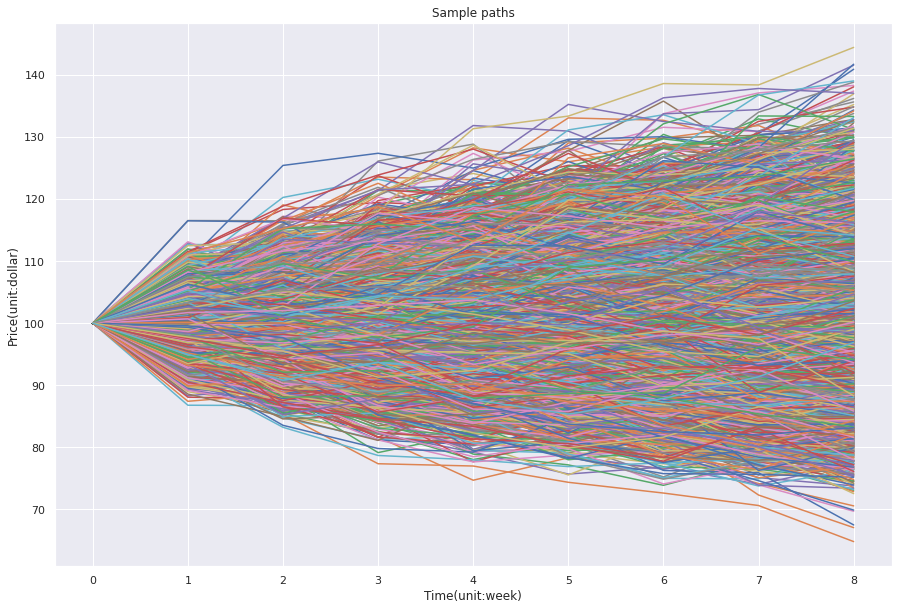

<Figure size 432x288 with 0 Axes>

In [7]:
sns.set()
x=np.arange(number_of_calculations_for_one_week_unit_time+1)
plt.figure(figsize=(15,10))
for i in range(sample_size):
  plt.plot(x,all_path[i])
plt.title('Sample paths')
plt.xlabel('Time(unit:week)')
plt.ylabel('Price(unit:dollar)')
plt.show()
plt.savefig('sample_paths.png')

# 2. Lattice

## (c)

In [8]:
u=np.exp(volatility*np.sqrt(delta_t))
d=np.exp(-volatility*np.sqrt(delta_t))
R=np.exp(risk_free_rate*delta_t)
q=(R-d)/(u-d)

number_of_row=2**number_of_calculations_for_one_week_unit_time
number_of_column=number_of_calculations_for_one_week_unit_time+1
lattice_path=np.zeros((number_of_row,number_of_column)).astype(float)


def recursion(arr):
  if arr[-1][-1]!=0:
    return arr
  else:
    for i in range(0,int(np.shape(arr)[0]/2)):
      arr[i][1]=arr[i][0]*u
    recursion(arr[0:int(np.shape(arr)[0]/2),1:])

    for j in range(int(np.shape(arr)[0]/2),np.shape(arr)[0]):
      arr[j][1]=arr[j][0]*d
    recursion(arr[int(np.shape(arr)[0]/2):np.shape(arr)[0],1:])

for i in range(0,number_of_row):
  lattice_path[i][0]=current_price

recursion(lattice_path)

def price_option_using_lattice(option_type,risk_free_rate,current_price,volatility,maturity_time_in_month,maturity_time_in_year,
                     number_of_calculations_for_one_week_unit_time,delta_t,sample_size):
  sample_price_list=[]
  for i in range(len(lattice_path)):    
    avg_value=sum(lattice_path[i])/len(lattice_path[i])
    max_value=max(lattice_path[i])
    min_value=min(lattice_path[i])
    if option_type=='Asian call':
      if avg_value>strike_price:
        sample_price_list.append((avg_value-strike_price)*np.exp(-risk_free_rate*maturity_time_in_year))
      else:
        sample_price_list.append(0)
    if option_type=='Asian put':
      if strike_price>avg_value:
        sample_price_list.append((strike_price-avg_value)*np.exp(-risk_free_rate*maturity_time_in_year))
      else:
        sample_price_list.append(0)
    if option_type=='Lookback call':
      if max_value>strike_price:
        sample_price_list.append((max_value-strike_price)*np.exp(-risk_free_rate*maturity_time_in_year))
      else:
        sample_price_list.append(0)
    if option_type=='Lookback put':
      if strike_price>min_value:
        sample_price_list.append((strike_price-min_value)*np.exp(-risk_free_rate*maturity_time_in_year))
      else:
        sample_price_list.append(0)
    if option_type=='Floating lookback call':
      if lattice_path[i][-1]>min_value:
        sample_price_list.append((lattice_path[i][-1]-min_value)*np.exp(-risk_free_rate*maturity_time_in_year))
      else:
        sample_price_list.append(0)
    if option_type=='Floating lookback put':
      if max_value>lattice_path[i][-1]:
        sample_price_list.append((max_value-lattice_path[i][-1])*np.exp(-risk_free_rate*maturity_time_in_year))
      else:
        sample_price_list.append(0)
  print(option_type,':')
  print('Price:')
  print(sum(sample_price_list)/len(sample_price_list))
  print('')

In [9]:
price_option_using_lattice('Asian call',risk_free_rate,current_price,volatility,maturity_time_in_month,maturity_time_in_year,
                     number_of_calculations_for_one_week_unit_time,delta_t,sample_size)
price_option_using_lattice('Asian put',risk_free_rate,current_price,volatility,maturity_time_in_month,maturity_time_in_year,
                     number_of_calculations_for_one_week_unit_time,delta_t,sample_size)
price_option_using_lattice('Lookback call',risk_free_rate,current_price,volatility,maturity_time_in_month,maturity_time_in_year,
                     number_of_calculations_for_one_week_unit_time,delta_t,sample_size)
price_option_using_lattice('Lookback put',risk_free_rate,current_price,volatility,maturity_time_in_month,maturity_time_in_year,
                     number_of_calculations_for_one_week_unit_time,delta_t,sample_size)
price_option_using_lattice('Floating lookback call',risk_free_rate,current_price,volatility,maturity_time_in_month,maturity_time_in_year,
                     number_of_calculations_for_one_week_unit_time,delta_t,sample_size)
price_option_using_lattice('Floating lookback put',risk_free_rate,current_price,volatility,maturity_time_in_month,maturity_time_in_year,
                     number_of_calculations_for_one_week_unit_time,delta_t,sample_size)

Asian call :
Price:
0.7125831574371972

Asian put :
Price:
5.435971264480178

Lookback call :
Price:
3.6508605272161985

Lookback put :
Price:
11.162681659945642

Floating lookback call :
Price:
6.699661664559857

Floating lookback put :
Price:
6.462218212941779



## (d)

In [10]:
lattice_path_value=np.zeros((number_of_row,number_of_column)).astype(float)

for i in range(number_of_row):
  for j in range(number_of_column):
    if lattice_path[i][j]>strike_price:
      lattice_path_value[i][j]=0
    else:
      lattice_path_value[i][j]=strike_price-lattice_path[i][j]

def recursion1(arr):
  if np.shape(arr)==(1,1):
    return
  else:  
    rightup=arr[0:int(np.shape(arr)[0]/2),1:]
    recursion1(rightup)
    ru=rightup[0][0]
    rightdown=arr[int(np.shape(arr)[0]/2):int(np.shape(arr)[0]),1:]
    recursion1(rightdown)
    rd=rightdown[0][0]
    center=arr[:,0:1]
    c=center[0][0]
    max_number=max(1/(1+risk_free_rate)*(q*ru+(1-q)*rd),c)
    center.fill(max_number)
  return arr
updated_value=recursion1(lattice_path_value)
print('American put:')
print('Price:')
print(updated_value[0][0])


American put:
Price:
6.437944941820292


In [11]:
a=pd.DataFrame(lattice_path)
a.to_excel('lattice_path.xlsx')